##  Exploratory Data Analysis

Importing the packages that we need

In [1240]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import soundfile
import glob, os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Convolution2D, MaxPooling2D, Conv2D

Sound is commonly analyzed subjectively by listening to it. However, when we want to analyze a sound objectively, we often switch domains, and change to visual or numerical displays. While it is likely that, generally speaking, the visual sense dominates other senses, when the data being explored are sound the question naturally arises as to whether these data may be statistically represented in that same domain.

In this project, I used the audio portion of the Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS). The dataset can be found in the link below. 

https://zenodo.org/record/1188976#.X96wxC3b2Cg

The database contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech includes calm, happy, sad, angry, fearful, surprise, and disgust expressions, and song contains calm, happy, sad, angry, and fearful emotions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

Audio-only files of all actors (01-24) are available as two separate zip files (~200 MB each):

- Speech file (Audio_Speech_Actors_01-24.zip, 215 MB) contains 1440 files: 60 trials per actor x 24 actors = 1440. 
- Song file (Audio_Song_Actors_01-24.zip, 198 MB) contains 1012 files: 44 trials per actor x 23 actors = 1012.

###  Speech Data

###  Amplitude and mel spectrogram

First I wanted to see how are the waveplot (blue plot) and and mel spectogram for each emotion:

In [1257]:
filelist_Sp_U = os.listdir('Desktop/unique_Emotion_Speech') 

<ipython-input-1313-8c7695f8704d>:21: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


<Figure size 648x216 with 0 Axes>

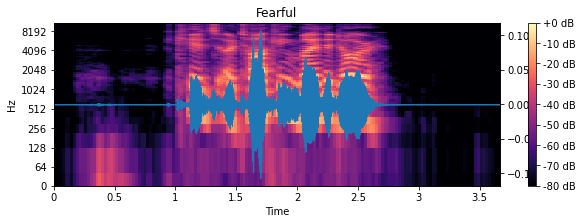

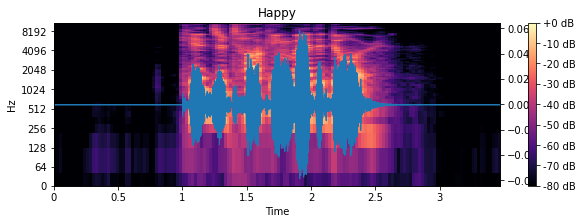

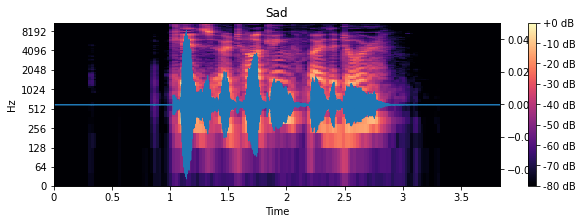

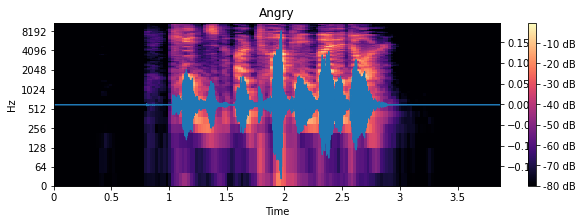

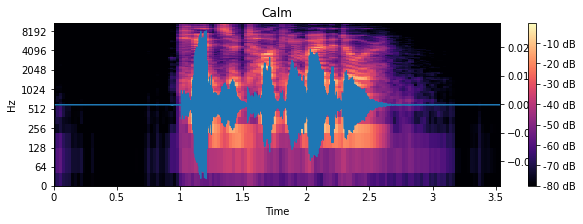

In [1313]:
# Plotting Waveplot and mel spectogram for speech audios:

emotions_U = ['Fearful' , 'Happy', 'Sad', 'Angry', 'Calm']



fig = plt.figure(figsize=(9, 3))
for i in range(0,5):
    
    
    y, fs = librosa.load('Desktop/unique_Emotion_Speech/'+filelist_Sp_U[i])
    fig = plt.figure(figsize=(10, 3)) #This setups the figure
    ax1 = fig.subplots() #Creates the Axes object to display one of the plots
    ax2 = ax1.twinx() #Creates a second Axes object that shares the x-axis
    S_U = librosa.feature.melspectrogram(y, sr=fs)
    img =librosa.display.specshow(librosa.power_to_db(S_U, ref=np.max), x_axis='time', y_axis='log', ax=ax1)
    librosa.display.waveplot(y, ax=ax2)
    plt.colorbar(img, ax=ax1, format="%+2.f dB")
    plt.title(emotions_U[i])
    
plt.show()

As we can see, the Fearful and Happy audio files have a bit similar plots. But in general, the difference in mel spectrograms for different emotions are not significant and cannot be differentiated by eye. Having said that, they do have different loudnesses plots except for `Happy` and `Fearful`.

###  Chromagram

As mentioned, a visual that could help analyze the audio files, is the chromagram. Below, I plotted the chromagram for different emotions audios of an actor.

/Users/roya/opt/anaconda3/envs/deeplearning2/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/roya/opt/anaconda3/envs/deeplearning2/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/roya/opt/anaconda3/envs/deeplearning2/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
<ipython-input-1311-d298cf8c0027>:16: UserWarning: Matplotlib is currently usin

<Figure size 648x288 with 0 Axes>

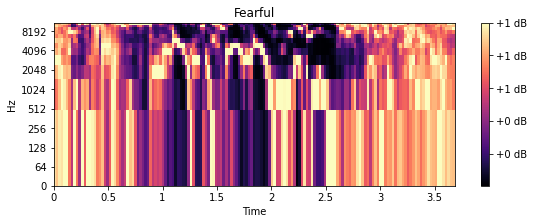

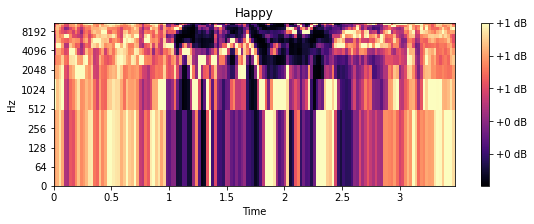

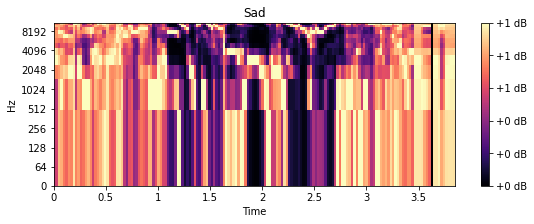

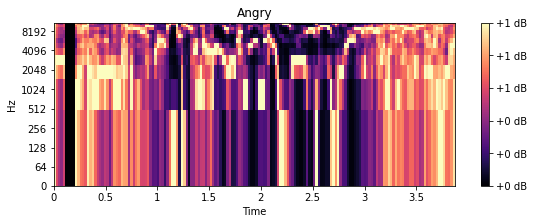

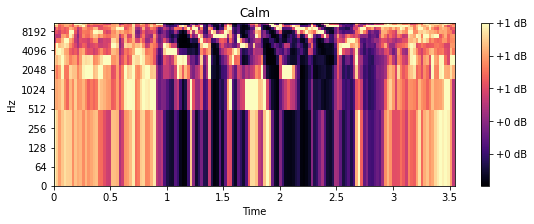

In [1311]:
#plotting chromagram for each emotion:

fig = plt.figure(figsize=(9, 4))
for i in range(0,5):
    
    fig = plt.figure(figsize=(9, 3))
    y, fs = librosa.load('Desktop/unique_Emotion_Speech/'+filelist_Sp_U[i])
    
    
      
    img1 =librosa.display.specshow(librosa.feature.chroma_stft(y=y), x_axis='time', y_axis='log')
    plt.colorbar(img1, format="%+2.f dB")
    
    plt.title(emotions_U[i])
   
    plt.show()

###  Loading data

After analyzing the emotions on loudness, me-spectogram and chromagram level, I need to extract the feature, discussed in Introduction part, for each audio files. I first started with speech audios and song audios were added towards the end of project.

In [1241]:
#list the speech audio files:
filelist_Sp = os.listdir('Desktop/Capstone_data') 

In [1242]:
#read them into pandas:
Speech_df = pd.DataFrame(filelist_Sp)
Speech_df = Speech_df.rename(columns={0:'file'})

In [1243]:
Speech_df.head()

,file
0,03-01-06-01-02-02-02.wav
1,03-01-05-01-02-01-16.wav
2,03-01-08-01-01-01-14.wav
3,03-01-06-01-02-02-16.wav
4,03-01-05-01-02-01-02.wav


In [1244]:
Speech_df.shape

(1440, 1)

The original speech dataset has 1440 audio files. In order to be able to compare the results  with Song audio file, I've picke 5 emotion as my target. 

In [1245]:
# listing the emotions i.e labels according to the dataset:

emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
#DataFlair - Emotions to observe (Picked these emotion so that I can use song audios)
picked_emotions=['calm', 'happy','sad','angry', 'fearful']


In [1246]:
# Separating the audio files with picked emotions and extraction the emotion of the audio file:


x_Sp,target_Sp=[],[]


for i in range(0,Speech_df.shape[0]):
  
    
    emotion = emotions[Speech_df['file'][i].split("-")[2]]
    
    if emotion in picked_emotions:
        x_Sp.append(Speech_df['file'][i])
        target_Sp.append(emotion)
        i+=1
    else:
        i +=1


In [1247]:
np.shape(x_Sp)

(960,)

In [1248]:
type(target_Sp)

list

Out of 1440 audio files, 960 had the emotions that I picked.

In [1249]:
x_Sp= pd.DataFrame(x_Sp)
x_Sp= x_Sp.rename(columns={0:'file'})

In [1301]:
target_SP=pd.DataFrame(target_Sp)
target_SP= target_SP.rename(columns={0: 'emotion'})
%store target_Sp

Stored 'target_Sp' (list)


In [1251]:
final_df_Sp = pd.concat([x_Sp,target_SP], axis=1)
%store final_df_Sp

Stored 'final_df_Sp' (DataFrame)


In [1252]:
final_df_Sp.head()

,file,emotion
0,03-01-06-01-02-02-02.wav,fearful
1,03-01-05-01-02-01-16.wav,angry
2,03-01-06-01-02-02-16.wav,fearful
3,03-01-05-01-02-01-02.wav,angry
4,03-01-02-01-02-01-12.wav,calm


In [1253]:
final_df_Sp.dtypes

file       object
emotion    object
dtype: object

Since I will use CNN model, I need to convert the target column to dummy variable:

In [1289]:
# convert the y column to dummy variables:

y_Sp = pd.get_dummies(target_Sp)
%store y_Sp

Stored 'y_Sp' (DataFrame)


In [1290]:
print(y_Sp.shape)
y_Sp.head(10)

(960, 5)


,angry,calm,fearful,happy,sad
0,0,0,1,0,0
1,1,0,0,0,0
2,0,0,1,0,0
3,1,0,0,0,0
4,0,1,0,0,0
5,0,1,0,0,0
6,0,1,0,0,0
7,0,1,0,0,0
8,0,0,1,0,0
9,1,0,0,0,0


Our target variable is ready for speech audio files.

###  Feature Extraction

As mentioned in introduction part, audio files have a lot of features and I have defined a function to extract them using librosa library.

In [1192]:
# Defining a function to extract the speech audio files features:

def extract_features_speech(files):
    

    file_name = os.path.join(os.path.abspath('Desktop/Capstone_data')+'/'+str(files.file))

    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    

    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=128).T,axis=0)

    stft = np.abs(librosa.stft(X))

    chroma = np.mean(librosa.feature.chroma_stft(X , S=stft, sr=sample_rate, n_chroma= 128,hop_length = 128).T,axis=0)

    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)

    return mfccs, chroma, mel

In [1193]:
# extracted 128 of each feature:

speech_features = final_df_Sp.apply(extract_features_speech, axis=1)

In [1199]:
type(speech_features)

pandas.core.series.Series

`speech_features` is a serie that has 960 elements representing 960 speech audio file and each element is a list with 3 element representing the three extracted features. 

Since I will use different modeling algorithms, I stacked the features in two different ways; first format, I concatenated them side by side for Logistic Regression and other algorithms. For the second format, feed for CNN model, I stacked them on top of each other.

In [1295]:
# Flattening the three features:

features_speech_flat = []

for i in range(0, len(speech_features)):
    features_speech_flat.append(np.concatenate((
        speech_features[i][0],
        speech_features[i][1], 
        speech_features[i][2]), axis=0))

#store the data to use in other notebook
%store features_speech_flat  

Stored 'features_speech_flat' (list)


In [1291]:
# Stacking the features and forming the final X dataset for CNN:

features_speech_CNN = []

for i in range(0, df.shape[0]):
    
    features_speech_CNN.append(np.row_stack([speech_features[i][0], speech_features[i][1], speech_features[i][2]]))
    

    
%store features_speech_CNN


Stored 'features_speech_CNN' (list)


In [1292]:
print(type(features_speech_flat))
print(np.shape(features_speech_flat))

<class 'list'>
(960, 384)


As we can see the flattened features dataset has 960 rows and 3*128 columns.

In [1205]:
print(type(features_speech_CNN))
print(np.shape(features_speech_CNN))

<class 'list'>
(960, 3, 128)


As expected, the stacked-features  dataset is a list with 960 elements representing each audio file and each of those elements are an array with 3 rows, mel, MFCC and chroma, and 128 columns.

### Scale analysis

We need to check to see if our features need scaling before feeding them into our models:

In [1209]:
# getting the maximum and minimum for mfcc feature:

Max_mfcc = []
Min_mfcc = []

for j in range (0, len(features_speech_CNN)):
    
    Max_mfcc.append( max(features_speech_CNN[j][0]))
    Min_mfcc.append( min(features_speech_CNN[j][0]))
    
print(max(Max_mfcc))
print(min(Min_mfcc))

100.78406
-852.9223


In [1210]:
# getting the maximum and minimum for chroma feature:

Max_chroma = []
Min_chroma = []

for j in range (0, len(features_speech_CNN)):
    
    Max_chroma.append( max(features_speech_CNN[j][1]))
    Min_chroma.append( min(features_speech_CNN[j][1]))
    
print(max(Max_chroma))
print(min(Min_chroma))

0.7618129
0.17918578


In [1211]:
# getting the maximum and minimum for mel feature:

Max_mel = []
Min_mel = []

for j in range (0, len(features_speech_CNN)):
    
    Max_mel.append( max(features_speech_CNN[j][2]))
    Min_mel.append(min(features_speech_CNN[j][2]))
    
print(max(Max_mel))
print(min(Min_mel))

162.43806
3.20113e-11


As we can see, the feature have a very differenct scale and they need to be scaled before using them for modeling.

At this point we have our speech data ready for modeling. Now we need to prepare the Song audio files data:

### Song Data

###  Loading data

I will follow the same process for song audio files to extract the features and prepare them for modeling.

In [1212]:
#list the files:
filelist_song = os.listdir('Desktop/Capstone_data_song') 

In [1215]:
#read them into pandas:
Song_df = pd.DataFrame(filelist_song)

# Renaming the column name to file:
Song_df = Song_df.rename(columns={0:'file'})

Song_df.head()

,file
0,03-02-03-02-02-02-16.wav
1,03-02-03-02-02-02-02.wav
2,03-02-04-02-02-02-12.wav
3,03-02-04-02-02-02-06.wav
4,03-02-04-01-01-02-06.wav


In [1216]:
# Adding the emotion column to the dataset to prepare the target column: 

x_So,target_So=[],[]


for i in range(0,Song_df.shape[0]):
  
    
    emotion = emotions[Song_df['file'][i].split("-")[2]]
    
    if emotion in picked_emotions:
        x_So.append(Song_df['file'][i])
        target_So.append(emotion)
        i+=1
    else:
        i +=1



In [1219]:
x_So= pd.DataFrame(x_So)
x_So= x_So.rename(columns={0:'file'})

In [1222]:
target_SO=pd.DataFrame(target_So)
target_SO= target_SO.rename(columns={0: 'emotion'})

In [1224]:
Song_df = pd.concat([x_So,target_SO], axis=1)
Song_df.head()

,file,emotion
0,03-02-03-02-02-02-16.wav,happy
1,03-02-03-02-02-02-02.wav,happy
2,03-02-04-02-02-02-12.wav,sad
3,03-02-04-02-02-02-06.wav,sad
4,03-02-04-01-01-02-06.wav,sad


Since the mel spectogram and other visuals will look like the speech data, I skipped plottign them for the sake of time.

In [1296]:
# convert the y column to dummy variables:

y_So = pd.get_dummies(target_So)
%store y_So

Stored 'y_So' (DataFrame)


In [1298]:
y_So.head()

,angry,calm,fearful,happy,sad
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1


###  Feature Extraction

In [1225]:
# Defining a function to extract the song audio files features:

def extract_features_song(files):
    
 
    file_name_s = os.path.join(os.path.abspath('Desktop/Capstone_data_song')+'/'+str(files.file))

    X_s, sample_rate_s = librosa.load(file_name_s, res_type='kaiser_fast')
    

    mfcc_s = np.mean(librosa.feature.mfcc(y=X_s, sr=sample_rate_s, n_mfcc=128).T,axis=0)

    stft = np.abs(librosa.stft(X_s))

    chroma_s = np.mean(librosa.feature.chroma_stft(X_s , S=stft, sr=sample_rate_s, n_chroma= 128,hop_length = 128).T,axis=0)

    mel_s = np.mean(librosa.feature.melspectrogram(X_s, sr=sample_rate_s).T,axis=0)
    
    return mfcc_s, chroma_s, mel_s

In [1226]:
# Extracted 128 of each feature:

song_features = Song_df.apply(extract_features_song, axis=1)

In [1299]:
# Flattening the three features for Song Audios:

features_song_flat = []

for i in range(0, len(song_features)):
    features_song_flat.append(np.concatenate((
        song_features[i][0],
        song_features[i][1], 
        song_features[i][2]), axis=0))
    
# store the features:
%store features_song_flat

Stored 'features_song_flat' (list)


In [1300]:
# Stacking the features and forming the final X dataset:

features_song_CNN = []

for i in range(0, Song_df.shape[0]):
    
    features_song_CNN.append(np.row_stack([song_features[i][0], song_features[i][1], song_features[i][2]]))
    
# store the feature:
%store features_song_CNN

Stored 'features_song_CNN' (list)


###  Scale Analysis

Given the scale of features for speech files, I expect to see different scales of features for song files as well. 

In [1235]:
# getting the maximum and minimum for mfcc feature:

Max_mfcc_song = []
Min_mfcc_song = []

for j in range (0, len(features_song_CNN)):
    
    Max_mfcc_song.append( max(features_song_CNN[j][0]))
    Min_mfcc_song.append( min(features_song_CNN[j][0]))
    
print(max(Max_mfcc_song))
print(min(Min_mfcc_song))

97.79409
-733.5518


In [1237]:
# getting the maximum and minimum for chroma feature:

Max_chroma_song = []
Min_chroma_song = []

for j in range (0, len(features_song_CNN)):
    
    Max_chroma_song.append( max(features_song_CNN[j][1]))
    Min_chroma_song.append( min(features_song_CNN[j][1]))
    
print(max(Max_chroma_song))
print(min(Min_chroma_song))

0.73486006
0.11116688


In [1238]:
# getting the maximum and minimum for mel feature:

Max_mel_song = []
Min_mel_song = []

for j in range (0, len(features_song_CNN)):
    
    Max_mel_song.append( max(features_song_CNN[j][2]))
    Min_mel_song.append(min(features_song_CNN[j][2]))
    
print(max(Max_mel_song))
print(min(Min_mel_song))

73.83295
6.785795e-11


As expected, they do have different-scale features and need scaling before any proper modeling.

Now the data are ready for modeling.